In [1]:
# Install dependencies
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 30.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=b6844952c57f9b228712ee3a44adf6058cf8daa7f6b06bbb5dc794e52386acb4
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 98.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data

In [2]:
# Import dependencies, check versions
import torch_geometric
import pandas as pd
import torch
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
# And some typing for code completion
from typing import Dict, List, Tuple, Union, Optional

print(torch.__version__)
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

"""
Should be:
1.13.1
2.2.0
"""
pass


1.13.1+cu116
2.3.0
Running on cuda


In [4]:
# Dataset location
# os.environ['DATASET_PATH'] = r'D:/Documents/FAKS/3. LETNIK/MLG/project-final/elliptic_bitcoin_dataset' # Uncomment this to add own path
is_running_from_local = 'DATASET_PATH' in os.environ
if is_running_from_local:
    print('DATA_PATH: ', os.environ['DATASET_PATH'])
    DATASET_PATH = os.environ['DATASET_PATH']
else:
    from google.colab import drive
    drive.mount('/content/drive')  # Check: !ls drive/MyDrive/
    DATASET_PATH = 'drive/MyDrive/elliptic_bitcoin_dataset/'
    print("Reading from Google Colab")
    print('DATA_PATH: ', DATASET_PATH)


Mounted at /content/drive
Reading from Google Colab
DATA_PATH:  drive/MyDrive/elliptic_bitcoin_dataset/


In [5]:
# Reading data to DataFrames
classes = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_classes.csv", index_col="txId")
edgelist = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_edgelist.csv")

# index is on top level timestamp, second level txId
features = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_features.csv", header=None, index_col=[1, 0])
features.index.names = ['timestamp', 'txId']

# That way, features are sorted by timestamp, as sample of first 5 columns shows:
display(features.loc[:, :5])

# TODO! Feature statistic/normalization

2         3         4          5
timestamp txId                                              
1         230425980 -0.171469 -0.184668 -1.201369  -0.121970
          5530458   -0.171484 -0.184668 -1.201369  -0.121970
          232022460 -0.172107 -0.184668 -1.201369  -0.121970
          232438397  0.163054  1.963790 -0.646376  12.409294
          230460314  1.011523 -0.081127 -1.201369   1.153668
...                       ...       ...       ...        ...
49        173077460 -0.145771 -0.163752  0.463609  -0.121970
          158577750 -0.165920 -0.123607  1.018602  -0.121970
          158375402 -0.172014 -0.078182  1.018602   0.028105
          158654197 -0.172842 -0.176622  1.018602  -0.121970
          157597225 -0.012037 -0.132276  0.463609  -0.121970

[203769 rows x 4 columns]

In [6]:
import seaborn as sns
sns.set_theme()

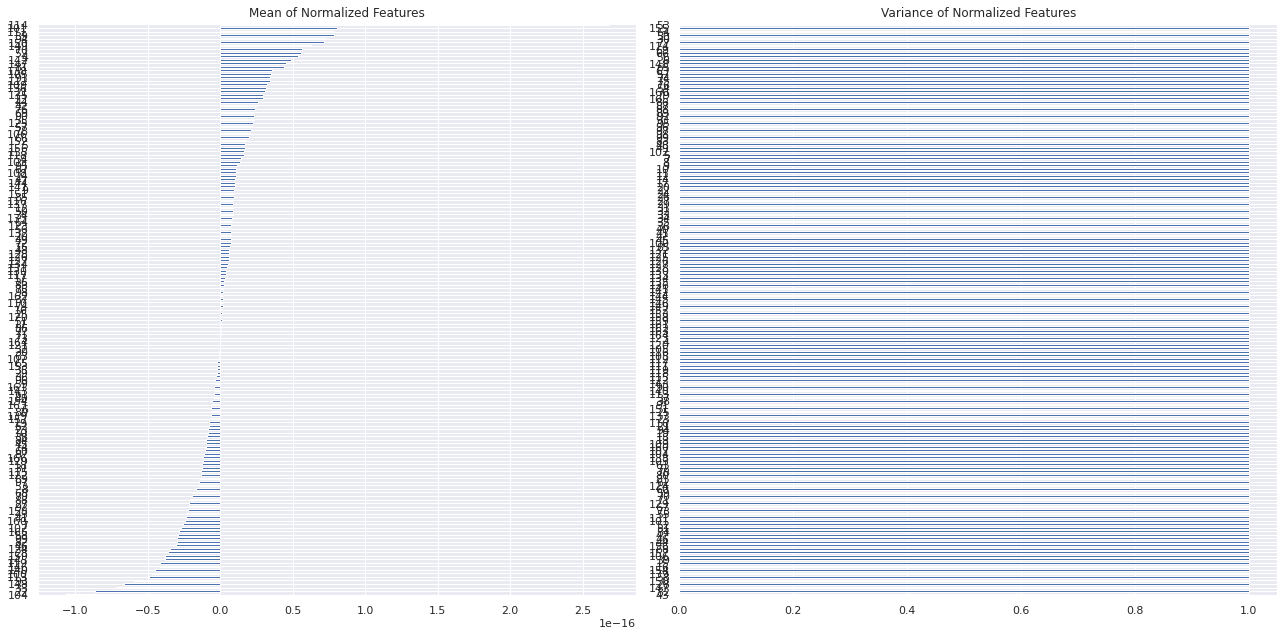

In [7]:
# feature normalization (mean = 0 && variance = 1)

#take only features, leave out subgraph index and txID
raw_features = features.iloc[:, 2:]

# create the scaler object
scaler = StandardScaler()

# fit the scaler on the features
scaler.fit(raw_features)

# normalize the features
normalize_features = scaler.transform(raw_features)

# convert back to DataFrame
normalize_features = pd.DataFrame(normalize_features, columns=raw_features.columns, index=raw_features.index)


# Calculate the mean and variance of each feature
mean = normalize_features.mean()
variance = normalize_features.var()

# Plot the mean and variance of each feature
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
mean.sort_values().plot(kind='barh')
plt.title('Mean of Normalized Features')
plt.subplot(1, 2, 2)
variance.sort_values().plot(kind='barh')
plt.title('Variance of Normalized Features')
plt.tight_layout()
plt.show()

# select the first two columns of df1
cols_to_add = features.iloc[:, :2]

# concatenate the selected columns with df2
normalized_features = pd.concat([cols_to_add, normalize_features], axis=1)

# TODO: we need somekind of a system to choose wheter we use normalized or original features for learning
# is visualization even required? it only shows that mean and var are actually what they need to be (interesting is that we have numerical errors visible at mean)

In [8]:
# Defining target classes
# Initial graph should be directed
directed_graph = nx.from_pandas_edgelist(
    edgelist, source='txId1', target='txId2', create_using=nx.DiGraph())
print(f"{nx.is_directed(directed_graph)=}")


ID_ILLICIT = 0  # Fraud
ID_LICIT = 1  # Legiet
ID_UNLABELED = 2 # Unknown

classes['y'] = classes['class'].replace(
    {'unknown': ID_UNLABELED, '1': ID_ILLICIT, '2': ID_LICIT})
class_mapping = classes[['y']].to_dict("dict")['y']

keys = features.index.get_level_values(1)
rows = torch.tensor(features.values, dtype=torch.double, device=device)
feature_mapping = dict(zip(keys, rows))


nx.is_directed(directed_graph)=True


In [9]:
# Subgraph splitting
timestamps = features.index.get_level_values(
    0).unique().sort_values().to_list()
ts_Tid_df = features.index.to_frame(index=False)
dataset = []
for ts in timestamps:
    # Get all txIds for a given timestamp
    sub_graph_idx = ts_Tid_df[ts_Tid_df.timestamp == ts].txId.to_list()
    # Create subgraph from the original graph
    s = directed_graph.subgraph(sub_graph_idx)
    nx.set_node_attributes(s, class_mapping, "y")
    nx.set_node_attributes(s, feature_mapping, "x")

    dataset.append(s)

# Takes ~20sec to run


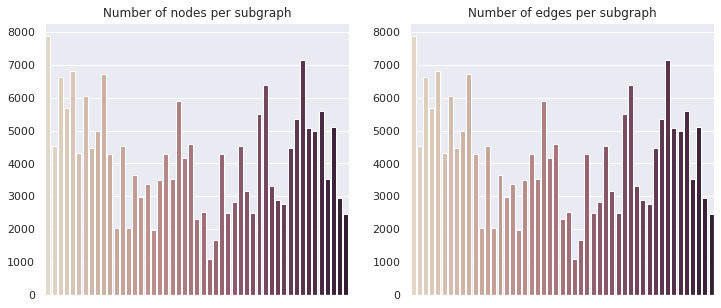

In [10]:
# Vertex/Edge count
node_dict = {i: len(subgraph.nodes) for i, subgraph in enumerate(dataset)}
edge_dict = {i: len(subgraph.edges) for i, subgraph in enumerate(dataset)}

# using seaborn implementation
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
node_indices = list(node_dict.keys())
node_count = list(node_dict.values())
nodes_graph = sns.barplot(ax=axes[0], x=node_indices, y=node_count, palette="ch:.25")
nodes_graph.set(xticklabels=[])
nodes_graph.set_title("Number of nodes per subgraph")

edge_indices = list(edge_dict.keys())
edge_count = list(edge_dict.values())
edge_graph = sns.barplot(ax=axes[1], x=node_indices, y=node_count, palette="ch:.25")
edge_graph.set(xticklabels=[])
_x = edge_graph.set_title("Number of edges per subgraph")


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


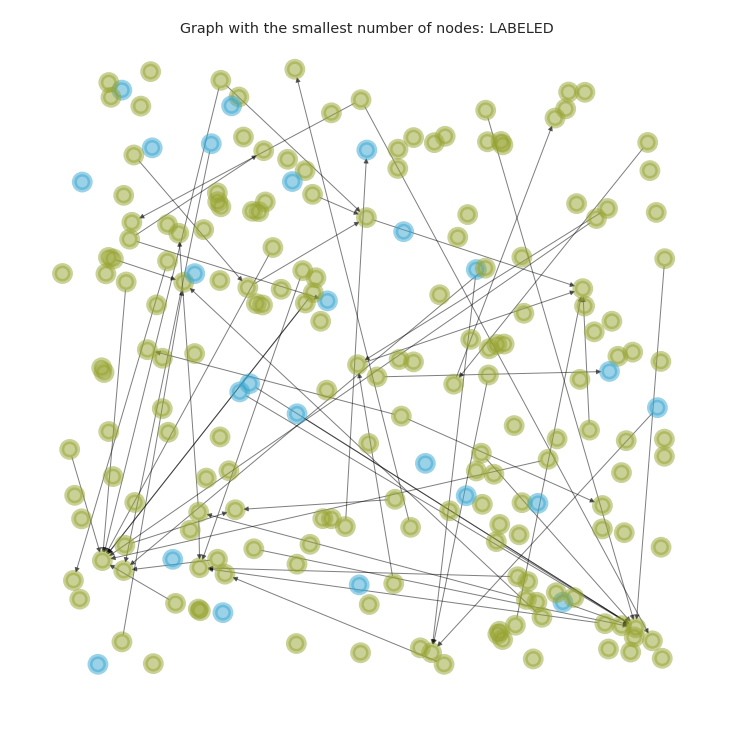

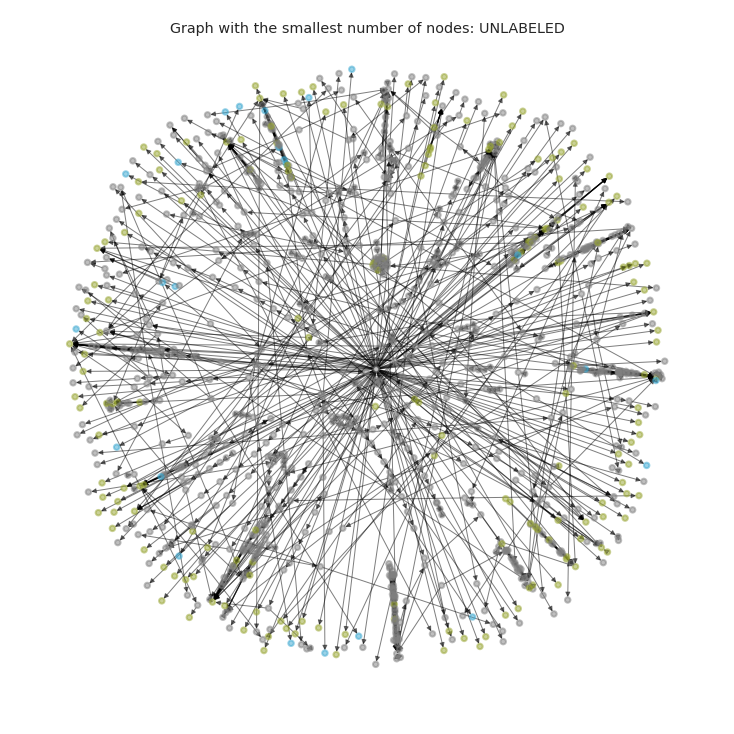

In [11]:
# Displaying the smallest subgraph
min_idx = min(node_dict, key=node_dict.get)
smallest_subgraph = dataset[min_idx]
labeled_nodes = [x for x,y in smallest_subgraph.nodes(data=True) if y['y']!=ID_UNLABELED]
labeled_graph = nx.induced_subgraph(smallest_subgraph, labeled_nodes)

palette = sns.color_palette("husl", 8)
color_map = {ID_UNLABELED: "gray", ID_LICIT: palette[2], ID_ILLICIT: palette[5]}
colors_labled = [color_map[attrs["y"]] for _, attrs in labeled_graph.nodes(data=True)]
colors_full = [color_map[attrs["y"]] for _, attrs in smallest_subgraph.nodes(data=True)]

fig1 = plt.figure(figsize=(10,10)) 
nx.draw_random(labeled_graph, node_color=colors_labled, node_size=250, linewidths=5, edge_color="black", alpha=0.5)

fig2 = plt.figure(figsize=(10,10))
nx.draw(smallest_subgraph, node_color=colors_full, node_size=30, linewidths=2, edge_color="black", alpha=0.5)

_x = fig1.suptitle("Graph with the smallest number of nodes: LABELED")
_x = fig2.suptitle("Graph with the smallest number of nodes: UNLABELED")


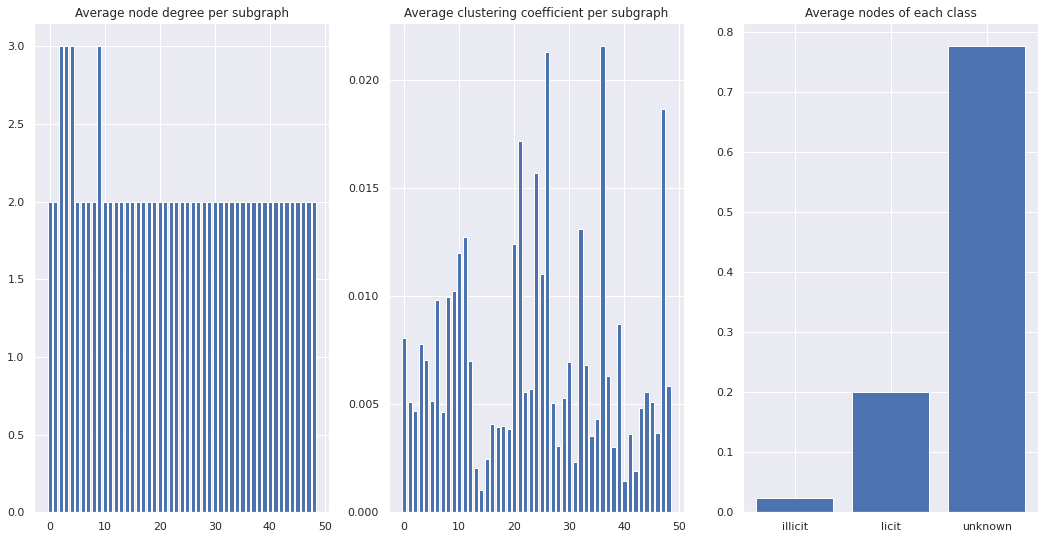

In [12]:
# some graph analysis
node_counter = np.array(list(node_dict.values()))
edge_counter = np.array(list(edge_dict.values()))
# a ma avg_degree sploh smisel, glede na to da so to transakcije? čeprov ne vem zakaj bi eni nodi mel degree > 2
avg_degree = np.round(2 * (edge_counter) / (node_counter))
avg_cluster_coef = np.round([nx.average_clustering(subgraph) for subgraph in dataset], 5)
no_of_classes = [np.bincount([attrs["y"] for _, attrs in subgraph.nodes(data=True)]) for subgraph in dataset]
avg_node_class = np.mean([[i / sum(x) for i in x]for x in no_of_classes], axis=0)
# print("average degrees:", avg_degree)
# print("average clustering coefficients:", avg_cluster_coef)
# print("number of nodes of each class in each of the subgraphs:", no_of_classes)

plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(dataset)), avg_degree)
plt.title("Average node degree per subgraph")

plt.subplot(1, 3, 2)
plt.bar(np.arange(len(dataset)), avg_cluster_coef)
plt.title("Average clustering coefficient per subgraph")

plt.subplot(1, 3, 3)
plt.bar(["illicit", "licit", "unknown"], avg_node_class)
plt.title("Average nodes of each class")

plt.show()
#todo: use Nina's sns configuration for histograms. (nimam zdele časa, grem na faks)

In [24]:
# Model definition
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F

class SM2_GCN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 conv_model: type[nn.Module],
                 nonlinearity: nn.Module,
                 num_hidden: int = 3,
                 conv_args: Dict = {},
                 dropout: float = 0.5):
        super(SM2_GCN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(
            conv_model(in_channels, hidden_channels, **conv_args)
        )
        self.bns.append(BatchNorm(hidden_channels))
        for _ in range(num_hidden):  # TODO!: BatchNorm or LayerNorm?
            self.convs.append(
                conv_model(hidden_channels, hidden_channels, **conv_args))
            self.bns.append(BatchNorm(hidden_channels))

        self.convs.append(
            conv_model(hidden_channels, out_channels, **conv_args))
        self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.nonlinearity = nonlinearity

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # TODO! Check dimensionality of x after GCNConv and GATConv
            x = self.nonlinearity(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
        x = F.softmax(x, dim=1)
        return x


In [99]:
# Testing Config
from dataclasses import dataclass, asdict, field

import json
import re


@dataclass
class TrainConfig:
    num_epoch: int = 10
    batch_size: int = 32
    test_split: float = 0.2
    random_state: Optional[int] = None

    # Optimizer
    optimizer_name: str = 'adam'
    lr: float = 0.01
    weight_decay: float = 5e-4

    def get_optimizer_for(self, model):
        if self.optimizer_name == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer name: {self.optimizer_name}")

    # Loss
    loss_name: str = 'cross_entropy'
    w = 0.85

    def get_loss(self):
        if self.loss_name == 'cross_entropy':
            return torch.nn.CrossEntropyLoss(weight=torch.Tensor([self.w, 1 - self.w]).to(device))
        if self.loss_name == 'bce':
            return torch.nn.BCEWithLogitsLoss()

        else:
            raise ValueError(f"Unknown loss name: {self.loss_name}")

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self



In [15]:
# Data loaders
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split


def get_data_loaders(config: TrainConfig, dataset: List[nx.Graph]):
    X_graphs = []
    for subgraph in dataset:
        _x = from_networkx(subgraph)
        _x.x = _x.x.to(device)
        _x.y = _x.y.to(device)
        X_graphs.append(_x)
    X_train, X_test = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    X_train, X_valid = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    # TODO! Decide on validation/K-fold split
    train_loader = DataLoader(
        X_train, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(X_test, batch_size=1, shuffle=False)
    return train_loader, test_loader


In [63]:
# Train
from tqdm.notebook import trange, tqdm

def train(model: SM2_GCN, data_loader: DataLoader, config: TrainConfig):
    dataset = data_loader.dataset
    loss_fn = config.get_loss()
    optimizer = config.get_optimizer_for(model)
    model.to(device)
    model.reset_parameters()
    model.train()
    for epoch in trange(config.num_epoch, unit="Epochs", desc="Training"):
        epoch_loss = 0

        # TODO! Per-epoch check and save best model - refernce in colab
        for batch in data_loader:
            optimizer.zero_grad()

            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            labeled_mask = (batch.y != ID_UNLABELED)
            loss = loss_fn(out[labeled_mask],
                           batch.y[labeled_mask])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
        avg_epoch_loss = epoch_loss / len(dataset)
        print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")


In [84]:
# Test
from sklearn.metrics import accuracy_score, f1_score, roc_curve


def test(model: nn.Module, data_loader: DataLoader):
    model.eval()
    allY = np.array([])
    allPred = np.array([])
    allProbPred = np.array([])
    with torch.no_grad():
        for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            consideration_index = batch.y != ID_UNLABELED
            
            probPred = out[consideration_index][:,1].cpu().numpy()
            allProbPred = np.append(allProbPred, probPred)
            pred = out[consideration_index].argmax(dim=1).cpu().numpy()
            allPred = np.append(allPred, pred)
            y = batch.y[consideration_index].cpu().numpy()
            allY = np.append(allY, y)
            acc = accuracy_score(y, pred)
            f1 = f1_score(y, pred, average="macro") # TODO! micro or macro?
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average="macro") # TODO! micro or macro?
    print(f"Total: Accuracy: {acc:.4f}, F1: {f1:.4f}")
    print(f"Real ratio: {len(allY[allY == 1])/len(allY)}, Pred ratio: {len(allPred[allPred == 1])/len(allPred)}")

    fpr, tpr, _ = roc_curve(allY, allProbPred)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [18]:
# Model Config

@dataclass
class ModelConfig:
    in_channels: int = -1
    hidden_channels: int = 64
    out_channels: int = 2
    num_hidden: int = 3
    conv_model: str = "GATConv"
    conv_args: dict = field(default_factory=dict)
    dropout: float = 0.5
    nonlinearity: str = 'leaky_relu(0.2)'

    def __nonlinearity(self):
        if self.nonlinearity == 'relu':
            return nn.ReLU()
        m = re.match(r'leaky_relu\((\d+\.?\d*)\)', self.nonlinearity)
        if m:
            return nn.LeakyReLU(float(m.group(1)))
        else:
            raise ValueError(f"Unknown nonlinearity: {self.nonlinearity}")

    def __model_type(self):
        if self.conv_model == "GATConv":
            return GATConv
        elif self.conv_model == "GCNConv":
            return GCNConv
        else:
            raise ValueError(f"Unknown model type: {self.conv_model}")

    def create(self):
        return SM2_GCN(in_channels=self.in_channels,
                       hidden_channels=self.hidden_channels,
                       out_channels=self.out_channels,
                       num_hidden=self.num_hidden,
                       conv_model=self.__model_type(),
                       conv_args=self.conv_args, dropout=self.dropout,
                       nonlinearity=self.__nonlinearity()
                )

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self


Training:   0%|          | 0/300 [00:00<?, ?Epochs/s]

Epoch 0, Loss: 0.7060
Epoch 1, Loss: 0.6728
Epoch 2, Loss: 0.6398
Epoch 3, Loss: 0.6251
Epoch 4, Loss: 0.6076
Epoch 5, Loss: 0.6006
Epoch 6, Loss: 0.5917
Epoch 7, Loss: 0.5800
Epoch 8, Loss: 0.5780
Epoch 9, Loss: 0.5680
Epoch 10, Loss: 0.5646
Epoch 11, Loss: 0.5602
Epoch 12, Loss: 0.5551
Epoch 13, Loss: 0.5551
Epoch 14, Loss: 0.5447
Epoch 15, Loss: 0.5476
Epoch 16, Loss: 0.5457
Epoch 17, Loss: 0.5422
Epoch 18, Loss: 0.5375
Epoch 19, Loss: 0.5370
Epoch 20, Loss: 0.5369
Epoch 21, Loss: 0.5352
Epoch 22, Loss: 0.5329
Epoch 23, Loss: 0.5332
Epoch 24, Loss: 0.5300
Epoch 25, Loss: 0.5249
Epoch 26, Loss: 0.5292
Epoch 27, Loss: 0.5218
Epoch 28, Loss: 0.5221
Epoch 29, Loss: 0.5188
Epoch 30, Loss: 0.5229
Epoch 31, Loss: 0.5204
Epoch 32, Loss: 0.5199
Epoch 33, Loss: 0.5173
Epoch 34, Loss: 0.5163
Epoch 35, Loss: 0.5170
Epoch 36, Loss: 0.5181
Epoch 37, Loss: 0.5185
Epoch 38, Loss: 0.5122
Epoch 39, Loss: 0.5137
Epoch 40, Loss: 0.5137
Epoch 41, Loss: 0.5111
Epoch 42, Loss: 0.5126
Epoch 43, Loss: 0.509

Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.8318, F1: 0.6140
Accuracy: 0.9006, F1: 0.6558
Accuracy: 0.8439, F1: 0.7559
Accuracy: 0.9606, F1: 0.5970
Accuracy: 0.8841, F1: 0.5107
Accuracy: 0.9220, F1: 0.6044
Accuracy: 0.8695, F1: 0.7180
Accuracy: 0.9112, F1: 0.7575
Accuracy: 0.9691, F1: 0.6660
Accuracy: 0.9570, F1: 0.5382
Total: Accuracy: 0.9570, F1: 0.5382
Real ratio: 0.9568661971830986, Pred ratio: 0.8870305164319249


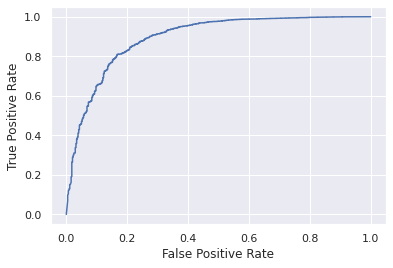

In [110]:
# All together now


fname = 'local_training_config.json'
try:
    config = TrainConfig.load(fname)
except FileNotFoundError:
    config = TrainConfig(
        num_epoch=10,
        batch_size=32,
        test_split=0.2,
        optimizer_name='adam',
        lr=0.01,
        weight_decay=5e-4,
        loss_name='cross_entropy'
    ).save(fname)

fname = 'local_model_config.json'
try:
    model_config = ModelConfig.load(fname)
except FileNotFoundError:
    model_config = ModelConfig(
        hidden_channels=64,
        num_hidden=3,
        conv_model='GATConv', conv_args={
            'heads': 4, 'concat': True},
        dropout=0.5,
        nonlinearity='leaky_relu(0.2)').save(fname)

model = model_config.create()
train_loader, test_loader = get_data_loaders(config, dataset)
train(model, train_loader, config)
test(model, test_loader)


In [111]:
from torch_geometric.nn import CorrectAndSmooth, LabelPropagation
# to je treba dosti lepse narest - just checking how it works
# ideja je basically da mas base model (manjka validation / whatever we decide to do, sm uporabla kar pac mamo)
# in output so pol soft labels - runnas correct and smooth in pol racunas accuracy testa 
# error je nekje v label propagationu correct koraka - neke dimenzije spet

cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.) # to lahko pol dost bl modifyamo, lahko se tudi svoj label propagation nrdi

def correct_and_smooth(model: nn.Module, data_loader: DataLoader):
        model.eval()
        with torch.no_grad():
                for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):

                        out = model(batch.x.float(), batch.edge_index)
                        labeled_mask = (batch.y != ID_UNLABELED)
                        y_soft = out.max(dim=1)[1].float() 
                        y_true = batch.y[labeled_mask].float()

                        y_soft = cs.correct(y_soft, y_true, labeled_mask, batch.edge_index)
                        pred = cs.smooth(y_soft, y_true, labeled_mask, batch.edge_index)

                        acc = accuracy_score(y_true, pred)
                        f1 = f1_score(y_true, pred, average="macro")
                        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

In [112]:
correct_and_smooth(model, test_loader)

Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

RuntimeError: ignored